# Блок 1: Аугментация с заменой слов на основе word2vec

In [ ]:
!wget http://rusvectores.org/static/models/rusvectores4/fasttext/araneum_none_fasttextcbow_300_5_2018.tgz

--2020-11-07 15:53:15--  http://rusvectores.org/static/models/rusvectores4/fasttext/araneum_none_fasttextcbow_300_5_2018.tgz
Resolving rusvectores.org (rusvectores.org)... 116.203.104.23
Connecting to rusvectores.org (rusvectores.org)|116.203.104.23|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2691248108 (2.5G) [application/x-gzip]
Saving to: ‘araneum_none_fasttextcbow_300_5_2018.tgz’

araneum_none_fastte 100%[===================>]   2.51G  27.1MB/s    in 99s     

2020-11-07 15:54:54 (26.0 MB/s) - ‘araneum_none_fasttextcbow_300_5_2018.tgz’ saved [2691248108/2691248108]



In [ ]:
!tar --gunzip --extract --verbose --file=araneum_none_fasttextcbow_300_5_2018.tgz

araneum_none_fasttextcbow_300_5_2018.model
araneum_none_fasttextcbow_300_5_2018.model.vectors_ngrams.npy
araneum_none_fasttextcbow_300_5_2018.model.vectors.npy
araneum_none_fasttextcbow_300_5_2018.model.vectors_vocab.npy


In [ ]:
pip install gensim==3.7.3

     |████████████████████████████████| 24.2MB 182kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
from gensim.models import KeyedVectors

In [ ]:
model_file = 'araneum_none_fasttextcbow_300_5_2018.model'
model = KeyedVectors.load(model_file)

In [ ]:
from razdel import tokenize
import pymorphy2

**Напишите функцию, которая заменяет слова во входном предложении их ближайшими семантическими ассоциатами.**

In [ ]:
morph = pymorphy2.MorphAnalyzer()

def augment_word2vec(sentence, model=model):
    tokens = [_.text for _ in tokenize(sentence) if _.text not in '1234567890,.!?-();:""«»—_–#' and '.' not in _.text]
    lemmas = [morph.parse(t)[0].normal_form for t in tokens]
    return ' '.join([model.most_similar(l, topn=1)[0][0] for l in lemmas if l in model])

In [ ]:
sent = 'мама помыла окно тряпкой))'

augment_word2vec(sent)

'мамочка мыть окошко тряпочка'

**Измените функцию так, чтобы заменялись слова, относящиеся к заданному набору пос-тегов (например, ADJ, NOUN), и сохранялась грамматика**

In [ ]:
def augment_word2vec_pos(sentence, model=model, 
                         list_of_pos=['NOUN','ADVB', 'PREP', 
                                      'CONJ', 'PRCL', 'INTJ']):
    tokens = [_.text for _ in tokenize(sentence) if _.text not in '1234567890,.!?-();:""«»—_–#' and '.' not in _.text]
    lemmas = [morph.parse(t)[0].normal_form for t in tokens]
    pos = [morph.parse(l)[0].tag.POS for l in lemmas]
    result = []
    for idx, lemma in enumerate(lemmas):
        if pos[idx] in list_of_pos:
            syn = model.most_similar(lemma, topn=1)[0][0]

            if pos[idx] == 'NOUN':
                p = morph.parse(tokens[idx])[0]
                result.append(morph.parse(syn)[0].inflect({p.tag.case, p.tag.number}).word)

            else:
                result.append(syn)

    return ' '.join(result)

In [ ]:
augment_word2vec_pos(sent)

'мамочка окошко тряпочкой'

# Блок 2: Регрессия; Medium Stories

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('gdrive')

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


In [ ]:
%cd /content/gdrive/My Drive/medium_stories

/content/gdrive/My Drive/medium_stories


In [ ]:
!ls

Medium_Clean.csv


In [ ]:
usecols = ['Title', 'Subtitle', 'Image', 'Author', 'Publication', 'Year', 'Month', 'Day', 'Reading_Time', 'Claps', 'url', 'Author_url']

df = pd.read_csv('Medium_Clean.csv', sep=",", usecols=usecols)
df['Claps'] = df['Claps'].astype(int)
df.head()

,Title,Subtitle,Image,Author,Publication,Year,Month,Day,Reading_Time,Claps,url,Author_url
0,Online Animation: Mixamo vs Norah AI,Online animations tools provide game designers...,1,Emma Laurent,NaN,2017,8,1,5,12,https://medium.com/@laurentemma/online-animati...,https://medium.com/@laurentemma
1,A.I. ?,NaN,0,Sanparith Marukatat,NaN,2017,8,1,2,11,https://medium.com/@sanparithmarukatat/a-i-%E0...,https://medium.com/@sanparithmarukatat
2,"Futures of AI, Friendly AI?",From Physics of the Future: How Science Will S...,1,Z,NaN,2017,8,1,3,1,https://medium.com/@otherside914/futures-of-ai...,https://medium.com/@otherside914
3,The Value Generated through AI led Mindfulness,A true product co-created by the Millennials,1,Emiko Sawaguchi,MILLENNIALSTIMES,2017,8,1,5,4,https://millennials-times.com/creativeflower-e...,https://millennials-times.com/@emikosawaguchi
4,"Os Melhores Links de JulhoCmeras Vintage, Goog...",mas pera a?,1,Giovani Ferreira,NEW ORDER,2017,8,1,3,56,https://medium.com/neworder/os-melhores-links-...,https://medium.com/@gferreira


In [ ]:
df = df[0:100000]

**Эксплоративный анализ данных**

In [ ]:
df.shape

(100000, 12)

In [ ]:
duplicate_rows_df = df[df.duplicated()]
print('количество дублирующихся рядов: ', duplicate_rows_df.shape)

количество дублирующихся рядов:  (0, 12)


In [ ]:
# до удаления рядов с нулевыми значениями
df.count() 

Title            96496
Subtitle         66566
Image           100000
Author          100000
Publication      30216
Year            100000
Month           100000
Day             100000
Reading_Time    100000
Claps           100000
url             100000
Author_url      100000
dtype: int64

In [ ]:
print(df.isnull().sum())

Title            3504
Subtitle        33434
Image               0
Author              0
Publication     69784
Year                0
Month               0
Day                 0
Reading_Time        0
Claps               0
url                 0
Author_url          0
dtype: int64


In [ ]:
df = df.dropna() 
df.count()

Title           18449
Subtitle        18449
Image           18449
Author          18449
Publication     18449
Year            18449
Month           18449
Day             18449
Reading_Time    18449
Claps           18449
url             18449
Author_url      18449
dtype: int64

In [ ]:
print(df.isnull().sum()) 

Title           0
Subtitle        0
Image           0
Author          0
Publication     0
Year            0
Month           0
Day             0
Reading_Time    0
Claps           0
url             0
Author_url      0
dtype: int64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18449 entries, 3 to 99995
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Title         18449 non-null  object
 1   Subtitle      18449 non-null  object
 2   Image         18449 non-null  int64 
 3   Author        18449 non-null  object
 4   Publication   18449 non-null  object
 5   Year          18449 non-null  int64 
 6   Month         18449 non-null  int64 
 7   Day           18449 non-null  int64 
 8   Reading_Time  18449 non-null  int64 
 9   Claps         18449 non-null  int64 
 10  url           18449 non-null  object
 11  Author_url    18449 non-null  object
dtypes: int64(6), object(6)
memory usage: 1.8+ MB


In [ ]:
# пропорция уникальных названий статей

len(df['Title'].unique()) / df.shape[0]

0.9842267873597484

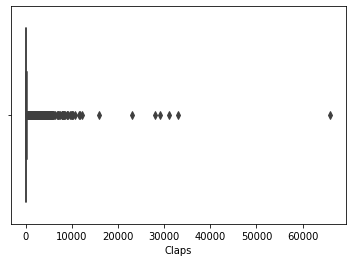

In [ ]:
sns.boxplot(x=df['Claps'])

,Image,Year,Month,Day,Reading_Time,Claps
Image,1.000000,0.019553,-0.007048,-0.003931,0.085553,0.040982
Year,0.019553,1.000000,-0.851447,-0.005136,0.016584,0.054471
Month,-0.007048,-0.851447,1.000000,-0.020899,0.002082,-0.034259
Day,-0.003931,-0.005136,-0.020899,1.000000,0.007665,-0.002626
Reading_Time,0.085553,0.016584,0.002082,0.007665,1.000000,0.092448
Claps,0.040982,0.054471,-0.034259,-0.002626,0.092448,1.000000


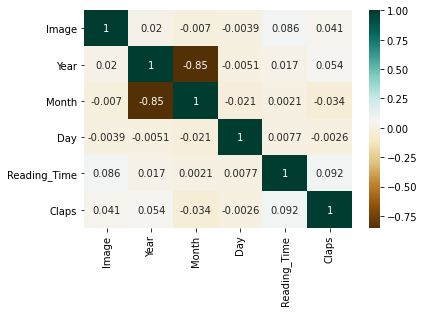

In [ ]:
# корреляция между переменными
c = df.corr()
sns.heatmap(c,cmap='BrBG',annot=True)
c

**Отбор важных признаков, поиск гиперпараметров, минимизация переобучения**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['Title'], df.Claps.values, 
                                                    test_size=0.3, random_state=42)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()

In [ ]:
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(12914, 16703) (5535, 16703) (12914,) (5535,)


In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import numpy as np

In [ ]:
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)
x_pred = lr.predict(X_test)
print('Negative RMSE: ', -np.sqrt(mean_squared_error(y_test, x_pred)))

Negative RMSE:  -1769.8447298037847


In [ ]:
# используем модель Ridge, где регуляризация задается l2-нормой
reg = linear_model.Ridge(alpha=0.1)
reg.fit(X_train, y_train)
x_pred = reg.predict(X_test)
print('Negative RMSE: ', -np.sqrt(mean_squared_error(y_test, x_pred)))

Negative RMSE:  -1268.4754141690344


In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
reg = linear_model.Ridge()

parameters = {'alpha' : [0.1, 1.0, 10.0],
              'normalize' : [False, True],
              'max_iter': [2,10,50]
              }

grid_search = GridSearchCV(reg, parameters, scoring='neg_root_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: -718.1556909807829
Best parameters: {'alpha': 1.0, 'max_iter': 2, 'normalize': True}


In [ ]:
model = linear_model.Ridge(**grid_search.best_params_)
model.fit(X_train, y_train)
x_pred = model.predict(X_test)

In [ ]:
pip install eli5

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

In [ ]:
eli5_weights = eli5.formatters.as_dataframe.explain_weights_df(model)

In [ ]:
# возьмем индексы 100 наиболее значимых признаков (слов из названий текстов)
features = [int(i[1:]) for i in eli5_weights.feature if 'BIAS' not in i][:100]

In [ ]:
top_features = [count_vect.get_feature_names()[i] for i in features]

In [ ]:
top_features

['phils',
 'theses',
 '95',
 'explainedsimply',
 'adamant',
 'struck',
 'walletsbest',
 'money20',
 'wom',
 'requiem',
 'clap',
 'alarming',
 'deeply',
 'heatmap',
 'celebs',
 'ubex',
 'thaler',
 'insolvency',
 'bitgrail',
 'slush',
 'equilibria',
 'planport',
 'unchain',
 'shadows',
 'bugs',
 'plandna',
 'onchain',
 'dawn',
 'shl',
 'illustrated',
 'opportunitiespart',
 'fostering',
 'directive',
 'curl',
 '400',
 'kotlinit',
 'stillwithher',
 'dpos',
 'strategists',
 'eosio',
 'eventum',
 'prefetching',
 'prl',
 'xpt',
 'layoutpreview',
 'dividends',
 'xrp',
 'ubuntu',
 'claims',
 'reclaims',
 'finalization',
 '2019',
 'chynge',
 'kids',
 'efinity',
 'attends',
 'magic',
 'bakers',
 'sobolev',
 'alexey',
 'heroic',
 'kills',
 'greve',
 'ethos',
 'touchbar',
 'skywire',
 'motionlayout',
 'tipspart',
 'schmidt',
 'primitives',
 'cryptoeconomic',
 'daggers',
 'sharp',
 'bfxthe',
 'sh',
 'bigco',
 'grain',
 'analytica',
 'validation',
 'omg',
 'nexo',
 'noticing',
 'spantastic',
 'spans'

**Адаптация аугментации данных с заменой слов**

In [ ]:
!wget http://vectors.nlpl.eu/repository/20/5.zip

--2020-11-06 21:33:08--  http://vectors.nlpl.eu/repository/20/5.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.225
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.225|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 574653290 (548M) [application/zip]
Saving to: ‘5.zip’

5.zip               100%[===================>] 548.03M  23.0MB/s    in 29s     

2020-11-06 21:33:37 (18.8 MB/s) - ‘5.zip’ saved [574653290/574653290]



In [ ]:
!unzip '5.zip'

Archive:  5.zip
  inflating: meta.json               
  inflating: model.bin               
  inflating: model.txt               
  inflating: README                  


In [ ]:
from gensim.models.keyedvectors import KeyedVectors

model = KeyedVectors.load_word2vec_format('model.bin', binary=True)
model.save_word2vec_format('model.txt', binary=False)

In [19]:
import nltk

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from nltk.stem import WordNetLemmatizer

In [ ]:
lemmatizer = WordNetLemmatizer()

def augment_word2vec_eng(sentence, model=model):
    tokens = [w for w in nltk.word_tokenize(sentence) if w not in '1234567890,.!?-();:""«»—_–#' and '.' not in w]
    lemmas = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join([model.most_similar(l, topn=1)[0][0] for l in lemmas if l in model])

In [ ]:
sent = 'My sister wants to go shopping.'

augment_word2vec_eng(sent)

'sibling wish a get mall'

**Конструирование текстовых признаков**

In [20]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [21]:
from nltk.corpus import stopwords

In [ ]:
# возвращает количество стоп-слов в тексте -- предположим, что чем меньше стоп-слов в названиях текстов, тем больше они будут нравиться читателям
stopWords = set(stopwords.words('english'))

def stopwords(text):
    return len([word for word in text.lower().split() if word in stopWords])

# возвращает 1 или 0 в зависимости от того, есть ли в названии слова из списка специальных слов
def special_vocab(text):
    if 'technology' or 'data' or 'science' in text.lower().split():
        return 1
    else:
        return 0

# признак: длина названия статьи
df['Title_len'] = df['Title'].apply(len)
# признак: длина подзаголовка статьи
df['Subtitle_len'] = df['Subtitle'].apply(len)
# признак: количество токенов в названии статьи
df['Title_len_tokens'] = df['Subtitle'].apply(lambda x: len(x.split()))
# признак: количество токенов в подзаголовке статьи
df['Subtitle_len_tokens'] = df['Subtitle'].apply(lambda x: len(x.split()))
# признак: количество стоп-слов в названии статьи
df['Title_len_stopwords'] = df['Title'].apply(stopwords)
# признак: количество стоп-слов в подзаголовке статьи
df['Subtitle_len_stopwords'] = df['Subtitle'].apply(stopwords)
# признак: наличие/отсутствие слов technology, data, science в названии статьи (используется, если не применяется представление признаков через векторайзер)
df['Title_spec_words'] = df['Title'].apply(special_vocab)
# признак: наличие/отсутствие слов technology, data, science в подзаголовке статьи (используется, если не применяется представление признаков через векторайзер)
df['Subtitle_spec_words'] = df['Subtitle'].apply(special_vocab)

In [ ]:
df.head()

,Title,Subtitle,Image,Author,Publication,Year,Month,Day,Reading_Time,Claps,url,Author_url,Title_len,Subtitle_len,Title_len_tokens,Subtitle_len_tokens,Title_len_stopwords,Subtitle_len_stopwords,Title_spec_words,Subtitle_spec_words
3,The Value Generated through AI led Mindfulness,A true product co-created by the Millennials,1,Emiko Sawaguchi,MILLENNIALSTIMES,2017,8,1,5,4,https://millennials-times.com/creativeflower-e...,https://millennials-times.com/@emikosawaguchi,46,44,7,7,2,3,1,1
4,"Os Melhores Links de JulhoCmeras Vintage, Goog...",mas pera a?,1,Giovani Ferreira,NEW ORDER,2017,8,1,3,56,https://medium.com/neworder/os-melhores-links-...,https://medium.com/@gferreira,71,11,3,3,0,0,1,1
5,The Future of AI: Redefining How We Imagine,Original article posted on FICO blogs,1,Syed Sadat Nazrul,Towards Data Science,2017,8,1,6,103,https://towardsdatascience.com/the-future-of-a...,https://towardsdatascience.com/@sadatnazrul,43,37,6,6,4,1,1,1
12,Serverless Prefabricated PaaS Accelerates Busi...,Serverless Computing accelerates time to,1,Hari Harikrishnan,The Cerebrus,2017,8,2,3,1,https://medium.com/cerebrus/from-rpc-to-server...,https://medium.com/@harikris,59,40,5,5,0,1,1,1
16,Chatbot2022630,Amie Chan 201781,0,Amie C.,Chatbots bible and More.,2017,8,2,1,2,https://medium.com/chatbots-bible-and-more/cha...,https://medium.com/@ameeee_c,14,17,3,3,0,0,1,1


**Сравнение качества моделей, выбор наилучшей**



In [ ]:
count_vect = CountVectorizer(max_features=100)

def get_X(text):
    data = count_vect.fit_transform(text)
    return pd.DataFrame(data.todense(), columns=count_vect.get_feature_names(), index=df.index)

In [ ]:
new_feat = df.drop(['Title', 'Subtitle', 'Author', 'Publication',
                    'url', 'Author_url', 'Title_spec_words', 'Subtitle_spec_words'], axis=1)  # оставляем только признаки с числовыми значениями
count_vect_df = get_X(df['Title'])

In [ ]:
print(count_vect_df.shape, new_feat.shape)

(18449, 100) (18449, 12)


In [ ]:
X = pd.concat([new_feat, count_vect_df], axis=1)

Вариант 1: ridge vs. lasso на совмещенных признаках (векторизация + новые текстовые признаки)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, df['Claps'], 
                                                    test_size=0.3, random_state=42)

In [ ]:
reg = linear_model.Ridge()

parameters = {'alpha' : [0.1, 1.0, 10.0],
              'normalize' : [False, True],
              'max_iter': [2, 10, 50, 1000]
              }

grid_search = GridSearchCV(reg, parameters, scoring='neg_root_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: -1.3511133396267861e-08
Best parameters: {'alpha': 0.1, 'max_iter': 2, 'normalize': False}


In [ ]:
model = linear_model.Ridge(**grid_search.best_params_)
model.fit(X_train, y_train)
x_pred = model.predict(X_test)
print('Negative RMSE: ', -np.sqrt(mean_squared_error(y_test, x_pred)))

Negative RMSE:  -1.644004217214244e-08


In [ ]:
lasso = linear_model.Lasso()

parameters = {'alpha' : [0.1, 1.0, 10.0],
              'normalize' : [False, True],
              'max_iter': [2, 10, 50, 1000]
              }

grid_search = GridSearchCV(lasso, parameters, scoring='neg_root_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: -0.00014001632816862728
Best parameters: {'alpha': 0.1, 'max_iter': 50, 'normalize': False}


In [ ]:
model = linear_model.Lasso(**grid_search.best_params_)
model.fit(X_train, y_train)
x_pred = model.predict(X_test)
print('Negative RMSE: ', -np.sqrt(mean_squared_error(y_test, x_pred)))

Negative RMSE:  -0.0002344501156045949


Вариант 2: ridge vs. lasso только на новых признаках

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Title', 'Subtitle', 
                                                             'Author', 'Publication', 'url', 
                                                             'Author_url'], axis=1), df['Claps'], 
                                                    test_size=0.3, random_state=42)

In [ ]:
reg = linear_model.Ridge()

parameters = {'alpha' : [0.1, 1.0, 10.0],
              'normalize' : [False, True],
              'max_iter': [2, 10, 50, 1000]
              }

grid_search = GridSearchCV(reg, parameters, scoring='neg_root_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: -1.3280220246830944e-08
Best parameters: {'alpha': 0.1, 'max_iter': 2, 'normalize': False}


In [ ]:
model = linear_model.Ridge(**grid_search.best_params_)
model.fit(X_train, y_train)
x_pred = model.predict(X_test)
print('Negative RMSE: ', -np.sqrt(mean_squared_error(y_test, x_pred)))

Negative RMSE:  -1.6150692429937167e-08


In [ ]:
lasso = linear_model.Lasso()

parameters = {'alpha' : [0.1, 1.0, 10.0],
              'normalize' : [False, True],
              'max_iter': [2, 10, 50, 1000]
              }

grid_search = GridSearchCV(lasso, parameters, scoring='neg_root_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: -0.0001408507014286525
Best parameters: {'alpha': 0.1, 'max_iter': 50, 'normalize': False}


In [ ]:
model = linear_model.Lasso(**grid_search.best_params_)
model.fit(X_train, y_train)
x_pred = model.predict(X_test)
print('Negative RMSE: ', -np.sqrt(mean_squared_error(y_test, x_pred)))

Negative RMSE:  -0.00020515811165598417


Вариант 3: ridge vs. lasso только на векторном представлении

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(count_vect_df, df['Claps'], 
                                                    test_size=0.3, random_state=42)

In [ ]:
reg = linear_model.Ridge()

parameters = {'alpha' : [0.1, 1.0, 10.0],
              'normalize' : [False, True],
              'max_iter': [2, 10, 50, 1000]
              }

grid_search = GridSearchCV(reg, parameters, scoring='neg_root_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: -729.7953289929471
Best parameters: {'alpha': 1.0, 'max_iter': 2, 'normalize': True}


In [ ]:
model = linear_model.Ridge(**grid_search.best_params_)
model.fit(X_train, y_train)
x_pred = model.predict(X_test)
print('Negative RMSE: ', -np.sqrt(mean_squared_error(y_test, x_pred)))

Negative RMSE:  -1120.1273020551419


In [ ]:
lasso = linear_model.Lasso()

parameters = {'alpha' : [0.1, 1.0, 10.0],
              'normalize' : [False, True],
              'max_iter': [2, 10, 50, 1000]
              }

grid_search = GridSearchCV(lasso, parameters, scoring='neg_root_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: -730.4770286695235
Best parameters: {'alpha': 1.0, 'max_iter': 10, 'normalize': False}


In [ ]:
model = linear_model.Lasso(**grid_search.best_params_)
model.fit(X_train, y_train)
x_pred = model.predict(X_test)
print('Negative RMSE: ', -np.sqrt(mean_squared_error(y_test, x_pred)))

Negative RMSE:  -1120.7519587411796


Наилучшее качество показывает модель Lasso на новых текстовых признаках (длина названия, количество токенов, количество стоп-слов, наличие специальных слов)

**Анализ ошибок**

При сравнении моделей в качестве признака векторизации использовался CountVectorizer с максимальной длиной вектора = 100 (это было сделано, потому что во время конкатенации более длинных векторов названий статей с новыми текстовыми признаками оперативная память исчерпывалась). Вероятно, в последнем варианте сравнения моделей получается такой высокий показатель ошибки из-за этого (при поиске наилучших параметров и важных признаков с Ridge использовался более длинный вектор, и ошибка была меньше).


# Блок 3: Paraphrase Detection

In [1]:
from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive


In [2]:
%cd /content/gdrive/My Drive/paraphraser

/content/gdrive/My Drive/paraphraser


In [3]:
!ls

araneum_none_fasttextcbow_300_5_2018.model
araneum_none_fasttextcbow_300_5_2018.model.vectors_ngrams.npy
araneum_none_fasttextcbow_300_5_2018.model.vectors.npy
araneum_none_fasttextcbow_300_5_2018.model.vectors_vocab.npy
araneum_none_fasttextcbow_300_5_2018.tgz
para.csv
paraphrases.tsv


In [5]:
para = pd.read_csv('paraphrases.tsv', sep='\t')
para.head()

,text_1,text_2,class
0,Совет юстиции Бразилии легализовал однополые б...,Совет юстиции Бразилии разрешил однополые браки.,1
1,"""Магнит"" поручится перед ""Абсолют Банком"" за к...",Выпуск сигарет в России упал из-за антитабачно...,-1
2,ЕС призвал США не бомбить Сирию до публикации ...,Евросоюз призвал США дождаться доклада ООН по ...,-1
3,Депо Московского метрополитена впервые перейде...,Частной компании впервые отдадут депо в москов...,1
4,Два человека погибли в столкновениях между кур...,Один человек погиб при столкновении судов у бе...,-1


**Эксплоративный анализ данных**

In [6]:
para.shape

(8540, 3)

In [7]:
duplicate_rows_df = para[para.duplicated()]
print('количество дублирующихся рядов: ', duplicate_rows_df.shape)

количество дублирующихся рядов:  (4283, 3)


In [8]:
# до удаления рядов с нулевыми значениями
para.count()

text_1    8540
text_2    8540
class     8540
dtype: int64

In [9]:
print(para.isnull().sum())

text_1    0
text_2    0
class     0
dtype: int64


In [10]:
para.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8540 entries, 0 to 8539
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text_1  8540 non-null   object
 1   text_2  8540 non-null   object
 2   class   8540 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 200.3+ KB


In [11]:
para['class'].value_counts(normalize=True)

-1    0.604684
 1    0.395316
Name: class, dtype: float64

In [12]:
len(para['text_1'].unique()) / para.shape[0]

0.4436768149882904

In [13]:
para = para.drop_duplicates(subset=['text_1'])
len(para['text_1'].unique()) / para.shape[0]

1.0

In [14]:
len(para['text_2'].unique()) / para.shape[0]

0.8722618105040908

In [15]:
para = para.drop_duplicates(subset=['text_2'])
len(para['text_2'].unique()) / para.shape[0]

1.0

In [16]:
para.shape

(3305, 3)

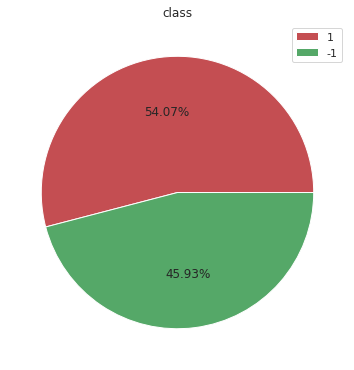

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(122)

column_values = list(para['class'].unique())

para.groupby('class').size().sort_values(ascending=False).plot(
        kind='pie', title='class', ax=ax, autopct='%.2f%%', labels=None, colors=['r', 'g']
    )
ax.legend(column_values)
ax.axis("off")

fig.tight_layout()

**Поиск гиперпараметров, минимизация переобучения**

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import linear_model

In [ ]:
para.head()

,text_1,text_2,class
0,Совет юстиции Бразилии легализовал однополые б...,Совет юстиции Бразилии разрешил однополые браки.,1
1,"""Магнит"" поручится перед ""Абсолют Банком"" за к...",Выпуск сигарет в России упал из-за антитабачно...,-1
2,ЕС призвал США не бомбить Сирию до публикации ...,Евросоюз призвал США дождаться доклада ООН по ...,-1
3,Депо Московского метрополитена впервые перейде...,Частной компании впервые отдадут депо в москов...,1
4,Два человека погибли в столкновениях между кур...,Один человек погиб при столкновении судов у бе...,-1


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(max_df=100, min_df=5)

In [ ]:
text_1 = tfidf_vect.fit_transform(para.text_1)
text_2 = tfidf_vect.transform(para.text_2)

In [ ]:
df1 = pd.DataFrame(text_1.toarray(), columns=tfidf_vect.get_feature_names())
df2 = pd.DataFrame(text_2.toarray(), columns=tfidf_vect.get_feature_names())

In [ ]:
X = pd.concat([df1, df2], axis=1)

In [ ]:
X.shape

(3789, 2032)

In [ ]:
y = para['class']
y.shape

(3789,)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
clf = linear_model.LogisticRegression()

parameters = {'class_weight' : ['balanced'], # баланс классов
                  'penalty' : ['l2', 'l1'],  # для минимизации переобучения
                  'solver' : ['liblinear', 'saga'],
                  'C' : [0.001, 0.01, 0.1, 1.0],
                  'max_iter': [2, 10, 50]
                 }

grid_search = GridSearchCV(clf, param_grid=parameters, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.6278435134847031
Best parameters: {'C': 1.0, 'class_weight': None, 'max_iter': 10, 'penalty': 'l2', 'solver': 'saga'}


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


**Сравнение качества моделей, выбор наилучшей**

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

(2652, 2032) (1137, 2032) (2652,) (1137,)


In [ ]:
true = pd.to_numeric(y_test)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()

parameter_grid = {'class_weight' : ['balanced'], # баланс классов
                  'splitter' : ['best', 'random'],
                  'max_depth' : [2, 10, 25, 100]}

grid_search = GridSearchCV(dtc, param_grid=parameter_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
dtc = DecisionTreeClassifier(**grid_search.best_params_)
dtc.fit(X_train, y_train)
predicted = dtc.predict(X_test)

acc = accuracy_score(true, predicted)
f1 = f1_score(true, predicted)
p = precision_score(true, predicted)
r = recall_score(true, predicted)
print('acc={0:1.4f}'.format(acc))
print('F1={0:1.4f}, Precision={1:1.4f}, Recall={2:1.4f}'.format(f1, p, r))

acc=0.5602
F1=0.6177, Precision=0.4897, Recall=0.8364


In [ ]:
clf = linear_model.LogisticRegression()

parameters = {'class_weight' : ['balanced'],
                  'penalty' : ['l2', 'l1'],  # для минимизации переобучения
                  'solver' : ['liblinear', 'saga'],
                  'C' : [0.001, 0.01, 0.1, 1.0],
                  'max_iter': [2, 10, 50]
                 }

grid_search = GridSearchCV(clf, param_grid=parameters, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

clf = linear_model.LogisticRegression(**grid_search.best_params_)
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)

acc = accuracy_score(true, predicted)
f1 = f1_score(true, predicted)
p = precision_score(true, predicted)
r = recall_score(true, predicted)
print('acc={0:1.4f}'.format(acc))
print('F1={0:1.4f}, Precision={1:1.4f}, Recall={2:1.4f}'.format(f1, p, r))

acc=0.6297
F1=0.5979, Precision=0.5550, Recall=0.6480


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

parameters = {'class_weight' : ['balanced', 'balanced_subsample'],
                  'n_estimators' : [10, 100, 150],  
                  'max_depth' : [None, 1.0, 10.0],
                  'max_samples': [2, 10, 50, None]
                 }

grid_search = GridSearchCV(rfc, param_grid=parameters, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

rfc = RandomForestClassifier(**grid_search.best_params_)
rfc.fit(X_train, y_train)
predicted = rfc.predict(X_test)

acc = accuracy_score(true, predicted)
f1 = f1_score(true, predicted)
p = precision_score(true, predicted)
r = recall_score(true, predicted)
print('acc={0:1.4f}'.format(acc))
print('F1={0:1.4f}, Precision={1:1.4f}, Recall={2:1.4f}'.format(f1, p, r))

acc=0.6297
F1=0.5794, Precision=0.5598, Recall=0.6004


Модели LogisticRegression, DecisionTreeClassifier, RandonForestClassifier с подобранными по gridsearch наилучшими параметрами показывают примерно одинаковое качество на данных без аугментации

**Аугментация данных**

In [ ]:
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas('PROGRESS>>>')
augment_text_1 = para['text_1'].progress_apply(augment_word2vec)

In [ ]:
augment_text_2 = para['text_2'].progress_apply(augment_word2vec)

In [ ]:
augment_df = pd.DataFrame({'augmet_text_1': augment_text_1, 
                           'augmet_text_2': augment_text_2})

In [ ]:
augment_df['class'] = para['class']

In [ ]:
augment_df.head()

,augmet_text_1,augmet_text_2,class
0,набсовет юстициар аргентина легализовывать раз...,набсовет юстициар аргентина разрешитель разноп...,1
1,фишмагнит поручаться пережа абсолютизм имэксба...,спецвыпуск сигаретка by россиия падать изза ан...,-1
2,евросоюз призва великобритания неї разбомбить ...,ес призва великобритания дожидаться содоклад м...,-1
3,электродепо немосковский метрополитан впервый ...,нечастный омпания впервый кайфовать электродеп...,1
4,дван постчеловек погиб by боестолкновение межд...,оди постчеловек погиб прив боестолкновение кор...,-1


**Конструирование текстовых признаков**

In [30]:
import razdel
from razdel import sentenize
from spacy.lang.ru import Russian
from spacy_russian_tokenizer import RussianTokenizer, MERGE_PATTERNS
import pymorphy2
from pymorphy2 import MorphAnalyzer

In [36]:
from nltk.corpus import stopwords

In [93]:
stopWords = stopwords.words('russian')

def stopwords_num(text):
    return len([word for word in text.lower().split() if word in stopWords])

def len_sent(text):
    num_sent = [len(s.text.split()) for s in sentenize(text)]
    return sum(num_sent)/len(num_sent)

def intersection(text_1, text_2):
    return len(set(text_tokenize(text_1).split() + text_tokenize(text_2).split()))

def num_token(text):
    nlp = Russian()
    doc = nlp(text)
    russian_tokenizer = RussianTokenizer(nlp, MERGE_PATTERNS)
    nlp.add_pipe(russian_tokenizer, name='russian_tokenizer')
    doc = nlp(text)
    token_text = ' '.join([token.text for token in doc if token.text not in ',.!?-();:""«»—_–#' and '.' not in token.text])
    return len(token_text.split())

def text_tokenize(text):
    nlp = Russian()
    doc = nlp(text)
    russian_tokenizer = RussianTokenizer(nlp, MERGE_PATTERNS)
    nlp.add_pipe(russian_tokenizer, name='russian_tokenizer')
    doc = nlp(text)
    return ' '.join([token.text for token in doc if token.text not in ',.!?-();:""«»—_–#' and '.' not in token.text])

In [61]:
inters = []
for i, row in para.iterrows():
    inters.append(intersection(row['text_1'], row['text_2']))

In [97]:
# количество пересекающихся слов в тексте 1 и тексте 2
para['Intersection_words'] = inters
# длина текста в символах
para['Text_1_len'] = para['text_1'].apply(len)
para['Text_2_len'] = para['text_2'].apply(len)
# средняя длина предложения (в словах)
para['Text_1_len_sent'] = para['text_1'].apply(len_sent)
para['Text_2_len_sent'] = para['text_2'].apply(len_sent)
# количество стоп-слов
para['Text_1_stopwords'] = para['text_1'].apply(stopwords_num)
para['Text_2_stopwords'] = para['text_2'].apply(stopwords_num)
# количество токенов
para['Text_1_tokens'] = para['text_1'].apply(num_token)
para['Text_2_tokens'] = para['text_2'].apply(num_token)
para.head()

,text_1,text_2,class,Intersection_words,Text_1_len,Text_2_len,Text_1_len_sent,Text_2_len_sent,Text_1_stopwords,Text_2_stopwords,Text_1_tokens,Text_2_tokens
0,Совет юстиции Бразилии легализовал однополые б...,Совет юстиции Бразилии разрешил однополые браки.,1,7,51,48,6.0,6.0,0,0,6,6
1,"""Магнит"" поручится перед ""Абсолют Банком"" за к...",Выпуск сигарет в России упал из-за антитабачно...,-1,19,68,56,11.0,8.0,3,1,11,8
2,ЕС призвал США не бомбить Сирию до публикации ...,Евросоюз призвал США дождаться доклада ООН по ...,-1,14,58,52,10.0,8.0,2,1,10,8
3,Депо Московского метрополитена впервые перейде...,Частной компании впервые отдадут депо в москов...,1,14,63,57,8.0,8.0,1,1,8,8
4,Два человека погибли в столкновениях между кур...,Один человек погиб при столкновении судов у бе...,-1,17,59,58,9.0,9.0,4,3,9,9


Так как для решения задачи детекции парафраз важны оба текста, можно применить какие-либо вычисления или сравнения к приведенным выше текстовым признакам (которые выделены для каждого текста), например, разность длин текстов, одинаковое ли количество стоп-слов в текстах и т.д.

**Анализ ошибок**

Метрики качества при классификации парафраз показывают не очень высокие результаты на всех выбранных моделях ([в статье](http://www.dialog-21.ru/media/3928/loukachevitchnvetal.pdf) они выше: acc=74-77, f-measure=80-81 для бинарной классификации). Это может быть связано с тем, что вместо текстовых признаков строк, частей речи и тезауруса был использован только признак тф-идф векторизация. Для доработки и уменьшения ошибок можно попробовать использовать новые текстовые признаки, кросс-валидацию и другие модели (GradientBoosting, SVM) 